In [1]:
#! /usr/bin/env python3
# https://github.com/huggingface/transformers/blob/main/examples/research_projects/rag-end2end-retriever/finetune_rag.py
import operator

import numpy as np
import psutil
from tqdm import tqdm
from sys import getsizeof
import sys
import os
from transformers import T5Tokenizer
from icecream import ic
import time
from transformers import (
    DPRContextEncoder,
    DPRQuestionEncoder,
    DPRContextEncoderTokenizerFast,
    DPRQuestionEncoderTokenizerFast,
    AutoTokenizer,
    AutoModel
)
import pandas as pd
import logging
import random
import re
import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

OSError: /opt/conda/lib/python3.6/site-packages/torchtext/_torchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

In [3]:
sys.path.append("../utils")
from data_utils import train_val_test_split_df
from file_utils import mkdir

# %%

logging.basicConfig(level=logging.INFO)
tqdm.pandas(miniters=10000, mininterval=60, maxinterval=600)

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["TOKENIZERS_PARALLELISM"] = "True"

In [56]:
def get_datasets(
        train_ds,
        train_corpus,
        val_ds,
        val_corpus,
        test_ds,
        test_corpus,
        text_column,
        nb_irrelevant
):
    df_train = pd.read_json(train_ds)
    corpus_train = CorpusDataset(path_to_file=train_corpus, text_column=text_column)
    df_val = pd.read_json(val_ds).sample(int(len(df_train) * .1))
    corpus_val = CorpusDataset(path_to_file=val_corpus, text_column=text_column)
    df_test = pd.read_json(test_ds)
    corpus_test = CorpusDataset(path_to_file=test_corpus, text_column=text_column)

    ds_train = QueryDataset(df=df_train,
                            text_column=text_column,
                            corpus=corpus_train,
                            nb_irrelevant=nb_irrelevant)
    ds_val = QueryDataset(df=df_val,
                          text_column=text_column,
                          corpus=corpus_val,
                          nb_irrelevant=nb_irrelevant)
    ds_test = QueryDataset(df=df_test,
                           text_column=text_column,
                           corpus=corpus_test,
                           nb_irrelevant=nb_irrelevant,
                           test=True)

    return ds_train, ds_val, ds_test

In [57]:
class CorpusDataset(pd.DataFrame):
    def __init__(self, path_to_file: str, text_column: str = None):
        super().__init__(self.get_df(path_to_file, text_column))

    @staticmethod
    def get_df(path, text_column):
        if path.endswith(".json"):
            df = pd.read_json(path, dtype={"id": str})
        elif path.endswith(".csv"):
            df = pd.read_csv(path)
        if "all" in text_column:
            df.rename(columns={"all_passage": "text"}, inplace=True)
        elif "first" in text_column:
            df.rename(columns={"first_sentence": "text"}, inplace=True)
        df = df.loc[df["text"] != "\n"]
        df["id"] = df["id"].apply(int)
        return df

In [58]:
class QueryDataset(Dataset):
    def __init__(self,
                 path_to_df: str = None,
                 df: pd.DataFrame = None,
                 text_column: str = None,
                 corpus: CorpusDataset = None,
                 nb_irrelevant=1,
                 test=False):

        assert operator.xor(path_to_df is not None, df is not None)

        self.df = self.get_df(path_to_df, df, text_column)
        self.corpus = corpus
        self.nb_irrelevant = nb_irrelevant
        self.count_doc = [0] * len(self.df)
        self.test = test

    @staticmethod
    def get_df(path=None, df=None, text_column=None):
        def parse_ids(ids_raw):
            if type(ids_raw) == str:
                ids_list = [ids[1:-1] for ids in ids_raw[1:-1].split(", ")]
                return ids_list
            elif type(ids_raw) == list:
                ids_int = [int(i) for i in ids_raw]
                return ids_int

        if path is not None:
            if path.endswith(".json"):
                df = pd.read_json(path)
            elif path.endswith(".csv"):
                df = pd.read_csv(path)

        df = df[["query",
                 "outline",
                 "text_" + text_column,
                 "id"]]
        df = df.loc[df["outline"].apply(len) > 0]
        df["text"] = df["text_" + text_column]
        df["id"] = df["id"].apply(parse_ids)
        df = df.loc[df["text"].apply(lambda text: text != "\n")]
        df = df[["query", "id"]]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        row = self.df.iloc[item]
        docs_id = row["id"]
        query = {"text": row["query"]}
        if self.test:
            query["ids"] = docs_id
            element = {"query": query}
        else:
            item_id = self.count_doc[item]
            positive = self.get_positive(docs_id[item_id])
            negatives = self.get_negatives(docs_id)
            element = {"query": query,
                       "positive": positive,
                       "negatives": negatives}
            self.count_doc[item] = (self.count_doc[item] + 1) % len(docs_id)
        return element

    def get_positive(self, doc_id):
        positive = {"doc_id": doc_id}
        row = self.corpus[self.corpus["id"] == doc_id]
        positive["text"] = row["text"].item()
        # positive["input_ids"] = row["input_ids"].values[0]
        # positive["attention_mask"] = row["attention_mask"].values[0]
        return positive

    def get_negatives(self, docs_id_positive):
        negatives_documents = []
        ids_selected = []
        for _ in range(self.nb_irrelevant):
            item_random = np.random.randint(0, len(self.corpus))
            row_negatives = self.corpus.iloc[item_random]
            while row_negatives["id"] in docs_id_positive + ids_selected:
                item_random = np.random.randint(0, len(self.corpus))
                row_negatives = self.corpus.iloc[item_random]
            ids_selected.append(row_negatives["id"])
            negatives = {"doc_id": row_negatives["id"],
                         "text": row_negatives["text"]}
            # "input_ids": row_negatives["input_ids"],
            # "attention_mask": row_negatives["attention_mask"]}
            negatives_documents.append(negatives)
        return negatives_documents

In [31]:
class DPR(pl.LightningModule):
    """
    Implementation of the DPR module :
    Encode all documents (contexts), and query with different BERT encoders.
    Similarity measure with dot product.
    """

    def __init__(self,
                 query_model_name: str,
                 context_model_name: str,
                 train_val_test: tuple,
                 freeze_params=-1,
                 batch_size=32,
                 num_workers=5,
                 learning_rate=1e-5):
        super().__init__()
        logging.info("\n\nWARNING about [query_tokenizer] :")
        # self.query_tokenizer = DPRQuestionEncoderTokenizerFast.from_pretrained(query_model_name)
        self.query_tokenizer = AutoTokenizer.from_pretrained(query_model_name)
        logging.info("\nWARNING about [context_tokenizer]")
        # self.context_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained(context_model_name)
        self.context_tokenizer = AutoTokenizer.from_pretrained(context_model_name)
        logging.info("\nWARNING about [query_model]")
        # self.query_model = DPRQuestionEncoder.from_pretrained(query_model_name)
        self.query_model = DPRQuestionEncoder.from_pretrained(query_model_name)
        logging.info("\nWARNING about [context_model]")
        # self.context_model = DPRContextEncoder.from_pretrained(context_model_name)
        self.context_model = DPRContextEncoder.from_pretrained(context_model_name)
        logging.info("\n\n")

        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.train_ds, self.val_ds, self.test_ds = train_val_test
        self.context_dense_tensor = None

        self.log_softmax = nn.LogSoftmax(dim=-1)
        self.loss_fn = self.get_loss_fn()

        if num_workers == -1:
            logging.info(f"Number of CPUs available : {psutil.cpu_count()}.")
            self.num_workers = psutil.cpu_count()
        else:
            self.num_workers = min(num_workers, psutil.cpu_count())

        if freeze_params != 0:
            self.freeze_params = freeze_params
            self.freeze_layers()

    # Freeze the first self.freeze_params % layers
    def freeze_layers(self):
        if self.freeze_params == -1:
            self.freeze_last_layers()
        else:
            num_query_layers = sum(1 for _ in self.query_model.parameters())
            num_context_layers = sum(1 for _ in self.context_model.parameters())

            for parameters in list(self.query_model.parameters())[:int(self.freeze_params * num_query_layers)]:
                parameters.requires_grad = False

            for parameters in list(self.query_model.parameters())[int(self.freeze_params * num_query_layers):]:
                parameters.requires_grad = True

            for parameters in list(self.context_model.parameters())[:int(self.freeze_params * num_context_layers)]:
                parameters.requires_grad = False

            for parameters in list(self.context_model.parameters())[int(self.freeze_params * num_context_layers):]:
                parameters.requires_grad = True

    def freeze_last_layers(self):
        for model in [self.query_model, self.context_model]:
            nb_layer = []
            for name, _ in model.named_parameters():
                try:
                    nb_layer.append(int(re.findall(r"layer\.\d+", name)[0].split(".")[-1]))
                except IndexError:
                    continue
            nb_layer = max(set(nb_layer))
            for name, param in model.named_parameters():
                if f'layer.{nb_layer}' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

    def encode_queries(self, query: dict):
        query_encoding = self.query_tokenizer(query["text"],
                                              truncation=True,
                                              max_length=512,
                                              padding="max_length",
                                              return_tensors="pt")
        query["input_ids"] = query_encoding["input_ids"]
        query["attention_mask"] = query_encoding["attention_mask"]
        return query

    def encode_contexts(self, contexts):
        def token_process(context):
            contexts_encoding = self.context_tokenizer(context["text"],
                                                       truncation=True,
                                                       max_length=512,
                                                       padding="max_length",
                                                       return_tensors='pt')
            context["input_ids"] = contexts_encoding["input_ids"]
            context["attention_mask"] = contexts_encoding["attention_mask"]
            return context

        if type(contexts) == list:
            for i in range(len(contexts)):
                contexts[i] = token_process(contexts[i])
        elif type(contexts) == dict:
            contexts = token_process(contexts)
        return contexts

    def decode_contexts(self, contexts_encodings: list):
        contexts = [self.context_tokenizer.decode(c) for c in contexts_encodings]
        return contexts

    def get_dense_query(self, query):
        query = self.encode_queries(query)
        dense_query = self.query_model(input_ids=query["input_ids"].to(self.device),
                                       attention_mask=query["attention_mask"].to(self.device))[
            "pooler_output"]
        return dense_query

    def get_dense_contexts(self, contexts):
        contexts = self.encode_contexts(contexts)
        dense_embeddings = []
        for context in contexts:
            embedding = self.context_model(input_ids=context["input_ids"].to(self.device),
                                           attention_mask=context["attention_mask"].to(self.device))
            dense_embeddings.append(embedding["pooler_output"])
        return torch.cat(dense_embeddings)

    @staticmethod
    def dot_product(query, contexts):
        sim = query.squeeze().matmul(contexts.T)
        return sim.squeeze()

    def train_dataloader(self):
        return DataLoader(copy.deepcopy(self.train_ds),
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          collate_fn=lambda x: x)

    def val_dataloader(self):
        return DataLoader(copy.deepcopy(self.val_ds),
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False,
                          collate_fn=lambda x: x)

    def test_dataloader(self):
        return DataLoader(copy.deepcopy(self.test_ds),
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False,
                          collate_fn=lambda x: x)

    def get_loss_fn(self, loss="nll"):
        """negative log likelihood from DPR paper."""
        if loss == "nll":
            nllloss = nn.NLLLoss()
            return lambda prediction: nllloss(prediction, torch.tensor(0).to(self.device))
        elif loss == "ce":
            cross_entropy = nn.CrossEntropyLoss()
            return lambda prediction: cross_entropy(prediction, torch.tensor(0).to(self.device))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        """
        :param query:
        :param return_contexts:
        :param k:
        :return:
        """
        self.context_model.train()
        self.query_model.train()
        loss = 0
        for data in batch:
            query_dense = self.get_dense_query(data["query"])
            contexts_dense = self.get_dense_contexts([data["positive"], *data["negatives"]])
            similarity_score = self.dot_product(query_dense, contexts_dense)
            logits = self.log_softmax(similarity_score)
            loss += self.loss_fn(logits)
            self.log('train/loss_step', loss.item(), on_step=True, batch_size=self.batch_size)

        self.log('train/loss_epoch', loss.item(), on_step=False, on_epoch=True, batch_size=self.batch_size)
        self.train_loss = loss
        return loss

    def training_epoch_end(self, outputs):
        logging.info(f'Finishing  epoch {str(self.current_epoch).rjust(5)} - loss : {str(self.train_loss).rjust(15)}')

    def validation_step(self, batch, batch_idx):
        self.context_model.eval()
        self.query_model.eval()
        loss = 0
        with torch.no_grad():
            for data in batch:
                query_dense = self.get_dense_query(data["query"])
                contexts_dense = self.get_dense_contexts([data["positive"], *data["negatives"]])
                similarity_score = self.dot_product(query_dense, contexts_dense)
                logits = self.log_softmax(similarity_score)
                loss += self.loss_fn(logits)
                self.log('Val/loss_step', loss.item(), on_step=True, batch_size=self.batch_size)

            self.log('Val/loss_epoch', loss.item(), on_step=False, on_epoch=True, batch_size=self.batch_size)
            self.val_loss = loss

    def validation_epoch_end(self, outputs):
        logging.info(f'Validation epoch {str(self.current_epoch).rjust(5)} - loss : {str(self.val_loss).rjust(15)}')

    def test_step(self, batch, batch_idx, k=10, dense_tensor_path="./dense_tensor.pt"):
        if dense_tensor_path:
            self.context_dense_tensor = torch.load(dense_tensor_path)
        self.context_model.eval()
        self.query_model.eval()
        for data in batch:
            query_dense = self.get_dense_query(data["query"])
            similarity_score = self.dot_product(query_dense, self.context_dense_tensor)
            top_k_item = similarity_score.argmax()[:k]
            top_k_corpus = self.test_ds.iloc(top_k_item)
            print("top_k_corpus :", top_k_corpus)
            print('data["query"]["ids"] :', data["query"]["ids"])
            print('acc :', sum([tkc in data["query"]["ids"] for tkc in top_k_corpus]))
            print()

            break

    def test_epoch_end(self, outputs):
        self.test_predictions = sum([output[0] for output in outputs], [])
        self.test_actuals = sum([output[1] for output in outputs], [])
        self.test_outlines = sum([output[2] for output in outputs], [])

    def encode_all_context_df(self,
                              contexts: pd.DataFrame = None,
                              load_tokens=None,  # ("./input_ids_tensor.pt", "./attention_mask_tensor.pt"),
                              step=32):
        if contexts is None:
            contexts = self.test_ds.corpus

        if load_tokens:
            input_ids_tensor = torch.load(load_tokens[0])
            attention_mask_tensor = torch.load(load_tokens[1])
        else:
            # tokenization
            def token_process(text):
                contexts_encoding = self.context_tokenizer(text,
                                                           truncation=True,
                                                           max_length=512,
                                                           padding="max_length",
                                                           return_tensors='pt')
                input_ids = contexts_encoding["input_ids"]
                attention_mask = contexts_encoding["attention_mask"]
                return input_ids, attention_mask

            input_ids_tensor = torch.zeros(size=(len(contexts), 512), dtype=torch.int)
            attention_mask_tensor = torch.zeros(size=(len(contexts), 512), dtype=torch.int)
            i = 0
            for text in tqdm(contexts["text"], miniters=10000, mininterval=60, maxinterval=600):
                input_ids_tensor[i], attention_mask_tensor[i] = token_process(text)
                i += 1

            torch.save(input_ids_tensor, "./input_ids_tensor.pt")
            torch.save(attention_mask_tensor, "./attention_mask_tensor.pt")

        # embedding
        dense_tensor = torch.zeros(size=(len(contexts), 768), dtype=torch.int)
        for i in tqdm(range(0, len(contexts), step),
                      miniters=80,
                      mininterval=1800,
                      maxinterval=3600):
            dense = self.context_model(input_ids=input_ids_tensor[i * step:(i + 1) * step],
                                       attention_mask=attention_mask_tensor[i * step:(i + 1) * step])
            torch.save(dense, f"./dense/dense_tensor.step-{i}.pt")
            dense_tensor[i * step:(i + 1) * step] = dense["pooler_output"]

        torch.save(dense_tensor, "./dense_tensor.pt")
        self.context_dense_tensor = dense_tensor
        return dense_tensor

    def predict(self, trainer):
        trainer.test(self)
        return self.test_predictions, self.test_actuals, self.test_outlines

NameError: name 'pl' is not defined

In [59]:
text_column="w_heading_first_sentence"
save_path_checkpoints="./checkpoints"
model_name="dpr_retriever"
nb_irrelevant=1
small=False
load_from_checkpoint=None  # "./checkpoints/dpr_retriever/version_3/checkpoints/epoch=0-step=1076.ckpt"

In [60]:
if small:
    path_to_file_prefix = "../../../data-subset_pre_processed/"
else:
    path_to_file_prefix = "../../../data-set_pre_processed/"

ds_train, ds_val, ds_test = get_datasets(
    train_ds=os.path.join(path_to_file_prefix, "fold-0/articles_train.json"),
    train_corpus=os.path.join(path_to_file_prefix, "fold-0/corpus_train.json"),
    val_ds=os.path.join(path_to_file_prefix, "fold-1/articles_train.json"),
    val_corpus=os.path.join(path_to_file_prefix, "fold-1/corpus_train.json"),
    test_ds=os.path.join(path_to_file_prefix, "test/articles_test.json"),
    test_corpus=os.path.join(path_to_file_prefix, "test/corpus_test.json"),
    text_column=text_column,
    nb_irrelevant=nb_irrelevant,
)

In [24]:
logger = pl_loggers.TensorBoardLogger(save_path_checkpoints, name=model_name)
checkpoint_callback = ModelCheckpoint(monitor="Val/loss_epoch",
                                      mode="min",
                                      save_last=True,
                                      save_top_k=5,
                                      every_n_epochs=1)

NameError: name 'pl_loggers' is not defined

In [ ]:
if torch.cuda.is_available():
    trainer = Trainer(logger=logger,
                      precision=32,
                      accelerator="gpu",
                      gpus=-1,
                      strategy='dp',
                      max_epochs=100,
                      callbacks=[checkpoint_callback],
                      log_every_n_steps=1,
                      progress_bar_refresh_rate=100)
else:
    trainer = Trainer(logger=logger,
                      precision=32,
                      accelerator="cpu",
                      max_epochs=50,
                      callbacks=[checkpoint_callback],
                      log_every_n_steps=1,
                      progress_bar_refresh_rate=100)

In [53]:
if load_from_checkpoint:
    dpr = DPR.load_from_checkpoint(load_from_checkpoint,
                                   context_model_name="facebook/dpr-ctx_encoder-single-nq-base",
                                   query_model_name="facebook/dpr-question_encoder-single-nq-base",
                                   train_val_test=(ds_train, ds_val, ds_test))
else:
    dpr = DPR(context_model_name="facebook/dpr-ctx_encoder-single-nq-base",
              query_model_name="facebook/dpr-question_encoder-single-nq-base",
              train_val_test=(ds_train, ds_val, ds_test))
    trainer.fit(model=dpr)

del dpr.train_ds
del dpr.val_ds

In [48]:
dpr.encode_all_context_df()

trainer.test(model=dpr)


True

# test phase

### agglomerate

In [14]:
tensors = []
for file in os.listdir("./tensors/dpr") :
    if file.startswith("dense_tensor.start") :
        print(file)
        start, end = re.findall(r"\d+", file)
        tensors.append([int(start), int(end), torch.load("./tensors/dpr/"+file)])

dense_tensor.start-1536_end-2304.pt
dense_tensor.start-3072_end-3840.pt
dense_tensor.start-2304_end-3072.pt
dense_tensor.start-4608_end-5376.pt
dense_tensor.start-5376_end-6181.pt
dense_tensor.start-3840_end-4608.pt
dense_tensor.start-768_end-1536.pt
dense_tensor.start-0_end-768.pt


In [20]:
dense = torch.zeros(size=(max(t[1] for t in tensors),768), dtype=torch.float64)

In [22]:
for t in tensors :
    a = t[0]
    b = t[1]
    dense[a:b] = t[2][a:b]

In [27]:
torch.save(dense, "./tensors/dpr/dense_epoch=27-step=30128.ckpt")

## PCA

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dense = torch.load("./tensors/dpr/articles_all_passage/dense.ckpt")

In [6]:
df = pd.read_json("./retrieved/dpr/articles_all_passage/df_test_retrieved.json")

In [46]:
df[df["query"] == "LinuxChix"]["text_w/o_heading_first_sentence"]

39    LinuxChix was founded in 1999 by Deb Richardso...
Name: text_w/o_heading_first_sentence, dtype: object

In [56]:
corpus = pd.read_json("../../../data-set_pre_processed/fold-0/corpus_train.json")

In [57]:
len(corpus)

1029897

In [27]:
corpus = pd.read_json("../../../data-set_pre_processed/test/corpus_test.json")

In [39]:
int(a)

1196857330044426351438405621829593837888930540929

In [53]:
np.where(corpus["first_sentence"].apply(lambda x : "LinuxChix was founded in 1999 by Deb Richardso" in x))

(array([2088]),)

In [41]:
any(corpus["id"] == int(a))

False

In [30]:
corpus[corpus["id"] == a]

,id,all_passage,first_sentence


In [67]:
for j in [0]:# range(len(ds_test)) :
    ilocs = []
    for i in ds_test[j]["query"]["ids"]:
        ilocs.append(np.where(ds_test.corpus[["id","text"]] == i)[0][0])
#         print(ds_test.get_positive(i))
#         print(np.where(ds_test.corpus[["id","text"]] == i)[0][0])

In [55]:
d = dense[2088]

In [71]:
dense.size()

torch.Size([6181, 768])

In [106]:
U,S,V = torch.pca_lowrank(dense, q=5)
U = U.detach().numpy()

<AxesSubplot:>

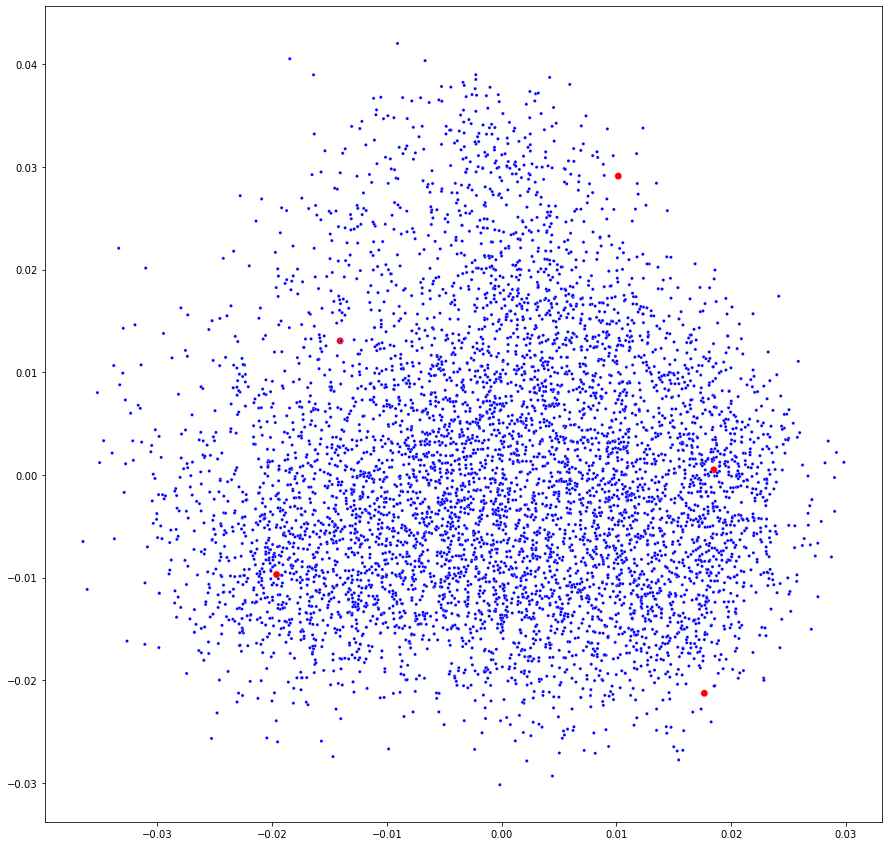

In [111]:
color = np.array(["blue"] * dense.size(0))
color[ilocs] = "red"
size = np.array([10] * dense.size(0))
size[ilocs] = 50

plt.figure(figsize=(15,15))
sns.scatterplot(x=U[:,0], y=U[:,1], c= color, s=size)

In [9]:
torch.tensor([0,3,4,-5]).argsort(descending=True)

tensor([2, 1, 0, 3])

In [14]:
a = [300687492647571812370426212799302446368843338771, 1029426746149931506335041158607817905766224796688, 27432961021104446026747158399232670758553440650, 1271770836076083624015513519192807928425420202935, 1371406029763017244866298937756020258756304975366, 324024004096749124835611468933917712228896406439, 156867484906645962236243021293906895361549913057, 218588674854977410852298118839564341858311510844, 1423475918282650524183488990327043923327304911489, 345545105981562654926182174800749123064848884218]
b = [300687492647571812370426212799302446368843338771, 218588674854977410852298118839564341858311510844, 1029426746149931506335041158607817905766224796688, 71065630688329986703694291875407073929832185370, 1292581487655919540192703025646037055664792170373, 396988797675347139307063712746295447725294379365, 603765024310901017844086199426411735301349109416, 864873522258929854856836572110251515726315871255]

In [16]:
print(len(a))
print(len(b))
print(len(set(a) & set(b)))
for a_i in a :
    print(a_i in b)

10
8
3
True
True
False
False
False
False
False
True
False
False
